In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layers

In [2]:
# Predictive model to predict if a patient has heart disease  based on the given criteria
# Data set provided by UC Irvine
# https://archive.ics.uci.edu/dataset/145/statlog+shuttle
# Statlog (Shuttle). UCI Machine Learning Repository. https://doi.org/10.24432/C5WS31.


# Reading data from .dat file
names = ['age',
         'sex',
         'chest_pain',
         'resting_bp',
         'cholestoral',
         'blood_sugar',
         'ecg',
         'max_heart_rate',
         'exercise_angian',
         'old_peak',
         'peak_exercise_slope',
         'major_vessels',
         'thal',
         'disease']

data = pd.read_csv('heart.dat', delimiter=' ', header=None)
data.columns = names

# Significant amount of one-hot encoding

encode = pd.get_dummies(data['disease'])
encode.columns = ['Absence', 'Presence']
data.pop('disease')
data = pd.concat([data, encode], axis='columns')

encode = pd.get_dummies(data['sex'])
encode.columns = ['Male', 'Female']
data.pop('sex')
data = pd.concat([data, encode], axis='columns')

encode = pd.get_dummies(data['blood_sugar'])
encode.columns = ['Under_120', 'Over_120']
data.pop('blood_sugar')
data = pd.concat([data, encode], axis='columns')

encode = pd.get_dummies(data['exercise_angian'])
encode.columns = ['No_angian', 'Angian']
data.pop('exercise_angian')
data = pd.concat([data, encode], axis='columns')

encode = pd.get_dummies(data['thal'])
encode.columns = ['normal', 'fixed', 'reverable']
data.pop('thal')
data = pd.concat([data, encode], axis='columns')

encode = pd.get_dummies(data['chest_pain'])
encode.columns = ['pain1', 'pain2', 'pain3', 'pain4']
data.pop('chest_pain')
data = pd.concat([data, encode], axis='columns')

encode = pd.get_dummies(data['ecg'])
encode.columns = ['ecg0', 'ecg1', 'ecg2']
data.pop('ecg')
data = pd.concat([data, encode], axis='columns')

In [3]:
# Separating labels from data and normalizing features

train_feature = data.sample(frac=.8, random_state=0)
test_feature = data.drop(train_feature.index)

train_label = pd.concat([train_feature.pop('Absence'), train_feature.pop('Presence')], axis='columns')
test_label = pd.concat([test_feature.pop('Absence'), test_feature.pop('Presence')], axis='columns')

normalizer = layers.Normalization()
normalizer.adapt(np.array(train_feature))

train_feature = normalizer(train_feature)
test_feature = normalizer(test_feature)

In [4]:
# Implementing the cost matrix of the model
# For diagnoses, the cost of missing a positive is more severe than a false positive, which is implemented as the cost matrix

cost_matrix = tf.constant([[1, 0], [0, 5]], dtype=tf.float32)
def custom_loss(y_true, y_pred):
    y_true_class = tf.argmax(y_true, axis=-1)
    y_pred_class = tf.argmax(y_pred, axis=-1)

    costs = tf.gather_nd(cost_matrix, tf.stack([y_true_class, y_pred_class], axis=1))
    return tf.reduce_mean(costs)

In [5]:
# Construct basic Sequential model to make classifications

model = tf.keras.Sequential()
model.add(layers.Input(shape=(train_feature.shape[1], )))
model.add(normalizer)
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(.5))
model.add(layers.Dense(2, activation='softmax'))

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=.01),
              metrics=['acc'],
             )

history = model.fit(x=train_feature,
                    y=train_label,
                    epochs=1000,
                    batch_size=64,
                    validation_split=.2,
                    callbacks = tf.keras.callbacks.EarlyStopping(monitor='acc', patience=200, restore_best_weights=True),
                   )

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - acc: 0.4483 - loss: 1.1663 - val_acc: 0.7955 - val_loss: 0.5260
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.6547 - loss: 0.8525 - val_acc: 0.7955 - val_loss: 0.5112
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.6771 - loss: 0.7938 - val_acc: 0.8182 - val_loss: 0.5326
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.6896 - loss: 0.6366 - val_acc: 0.7955 - val_loss: 0.4904
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.7949 - loss: 0.5307 - val_acc: 0.7955 - val_loss: 0.4753
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.7626 - loss: 0.5339 - val_acc: 0.8182 - val_loss: 0.4910
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.8434 - loss: 0.4763 - val_acc: 0.8182 - val_loss: 0.5251
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.7869 - loss: 0.5566 - val_acc: 0.8182 - val_loss: 0.4957
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.8240

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.8947 - loss: 0.6987 
Accuracy: 0.8888888955116272	Loss: 0.6828384399414062


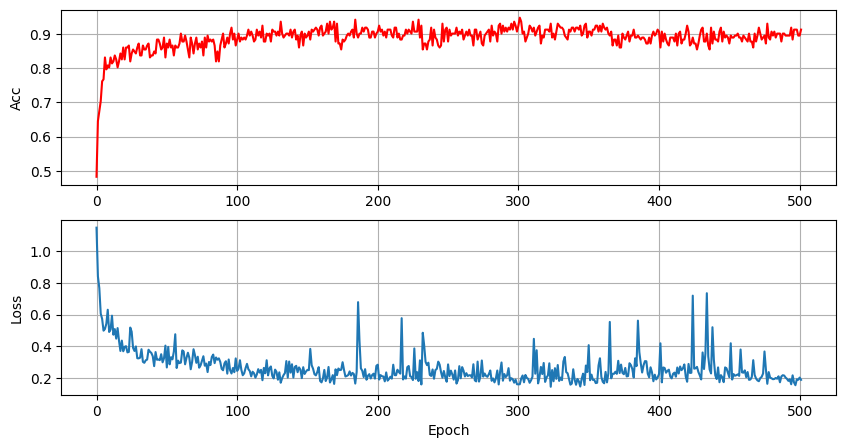

In [6]:
# Graphing and Analyzing data 
loss, acc = model.evaluate(test_feature, test_label)
print(f'Accuracy: {acc}\tLoss: {loss}')

def plot_history(history):
    fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(10,5))
    ax[0].plot(history.history['acc'], color='red', label='Acc')
    ax[0].set_ylabel('Acc')
    ax[0].grid(True)
    ax[1].plot(history.history['loss'], label='loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].grid(True)
    

hist = pd.DataFrame(history.history)
plot_history(history)


In [7]:
# Interpreting results
# Data is highly accurate, 80%+ and favoring to overpredict the presence, as intended

pred = np.round(model.predict(test_feature)).astype(int)
test_label = np.array(test_label)
print(f'Predicted Results || Absence: {sum(pred[:,0])} Presence: {sum(pred[:,1])}')
print(f'Actual Results    || Absence: {sum(test_label[:,0])} Presence: {sum(test_label[:,1])}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Results || Absence: 32 Presence: 22
Actual Results    || Absence: 32 Presence: 22


In [8]:
model.save('heart_disease.keras')